In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- [X] Reshape from wide → long format (`Country`, `Year`, `GDP_per_capita`).
- [X] Handle missing values:
  - [X] Drop countries with >30% missing data.
  - [X] Fill missing GDP values with linear interpolation.

In [195]:
df = pd.read_csv("./data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv", skiprows=4)

In [196]:
data = df.copy()

In [197]:
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.121835,186.941781,197.402402,225.440494,208.999748,226.876513,...,1329.807285,1520.212231,1538.901679,1493.817938,1344.103210,1522.393346,1628.318944,1568.159891,1673.841139,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,121.939925,127.454189,133.827044,139.008291,148.549379,155.565216,...,1630.039447,1574.230560,1720.140280,1798.340685,1680.039332,1765.954788,1796.668633,1599.392983,1284.154441,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2309.534130,2122.083690,NaN


In [198]:
# Reshape from wide → long format (`Country`, `Year`, `GDP_per_capita`).
rows = []
for row in data.iterrows():
    country = row[1]["Country Name"]
    country_code = row[1]["Country Code"]
    for year in range(1960, 2025):
        new_row = {"Country": country,
                   "Country_Code": country_code,
                   "Year": year,
                   "GDP_per_capita": row[1][str(year)]}
        rows.append(new_row)
data_long = pd.DataFrame(rows)
data_long = data_long.reset_index(drop=True)

In [199]:
# Handle missing values:
#   Drop countries with >30% missing data.
#   Fill missing GDP values with linear interpolation.# Convert Year column to integer and GDP to numeric.

missing = data_long.groupby("Country")["GDP_per_capita"].apply(lambda x: x.isna().sum())
size = data_long.groupby("Country").size()
missing_ratio = missing / size

In [200]:
countries_to_drop = missing_ratio[missing_ratio > 0.3].index
data_long = data_long[~data_long["Country"].isin(countries_to_drop)]

In [201]:
data_long["GDP_per_capita"] = data_long["GDP_per_capita"].interpolate(method="linear")

- [X] Compute the **global mean GDP per capita** per year (line plot).
- [X] Identify the **richest 10 and poorest 10 countries** in the latest available year.
- [X] Compute **year-to-year percentage growth** for a few sample countries.
- [X] Use NumPy to:
  - [X] Calculate global mean, median, and standard deviation for each year.
  - [X] Identify years with unusually high volatility (std dev spikes).

In [202]:
# Compute the global mean GDP per capita per year (line plot).
global_gdp_per_year = data_long.groupby("Year")["GDP_per_capita"].mean()

In [203]:
#  Identify the richest 10 and poorest 10 countries in the latest available year.
latest_year = data_long["Year"].max()
latest_year_gdp_data = data_long[data_long["Year"] == latest_year].dropna().sort_values(
    "GDP_per_capita", ascending=False)
poorest_ten = latest_year_gdp_data.tail(10)
richest_ten = latest_year_gdp_data.head(10)

In [204]:
# Compute year-to-year percentage growth for a few sample countries.
countries = np.array(["China", "United States", "Germany", "Turkiye"])
pct_growth_per_year = pd.DataFrame(columns=countries, index=range(data_long["Year"].min(), data_long["Year"].max() + 1))

for country in countries:
    country_data = data_long[data_long["Country"] == country].sort_values("Year").reset_index(drop=True)
    pct_growth = country_data["GDP_per_capita"].pct_change()
    pct_growth_per_year[country] = pct_growth.values

pct_growth_per_year

,China,United States,Germany,Turkiye
1960,NaN,NaN,NaN,NaN
1961,-0.153258,0.020281,0.132331,0.027181
1962,-0.064553,0.058402,0.087098,0.087079
1963,0.047937,0.040563,0.050075,0.130025
1964,0.150305,0.059201,0.090071,0.051468
...,...,...,...,...
2020,0.027513,-0.012670,-0.005126,-0.062580
2021,0.212654,0.107232,0.103122,0.127851
2022,0.006454,0.091905,-0.049354,0.095584
2023,-0.001498,0.057072,0.085623,0.227753


In [205]:
# Use NumPy to:
#   Calculate global mean, median, and standard deviation for each year.
#   Identify years with unusually high volatility (std dev spikes).
data_long.groupby("Year")["GDP_per_capita"].mean()

Year
1960     3821.655615
1961     3250.622696
1962     2856.368713
1963     2507.240473
1964     2168.600200
            ...     
2020    16846.293181
2021    19412.031519
2022    20049.416558
2023    20772.478072
2024    19864.352360
Name: GDP_per_capita, Length: 65, dtype: float64

In [206]:
data_long.groupby("Year")["GDP_per_capita"].median()


Year
1960     355.846240
1961     344.849890
1962     335.221589
1963     364.743594
1964     374.175829
           ...     
2020    5722.480995
2021    6681.708952
2022    6909.352818
2023    7000.836605
2024    7466.651865
Name: GDP_per_capita, Length: 65, dtype: float64

In [207]:
gdp_std_per_year = data_long.groupby("Year")["GDP_per_capita"].std()
gdp_std_per_year

Year
1960    10958.694593
1961     9338.797350
1962     7887.725929
1963     6534.912129
1964     5327.442787
            ...     
2020    25995.070127
2021    30947.967573
2022    31097.394351
2023    33053.800829
2024    27511.464140
Name: GDP_per_capita, Length: 65, dtype: float64

In [208]:
volatility_threshold = gdp_std_per_year.mean() + 2 * gdp_std_per_year.std()
gdp_std_per_year[gdp_std_per_year > volatility_threshold]

Year
2023    33053.800829
Name: GDP_per_capita, dtype: float64

- [X] Add a mapping: Country → Continent (manual or external dataset).
- [X] Group by continent:
  - [X] Compute average GDP per capita per year.
  - [X] Plot trend lines for each continent (one line per continent).

In [209]:
continents_data = pd.read_csv("./data/country-and-continent-codes-list.csv")

In [210]:
# Add a mapping: Country → Continent (manual or external dataset).
data_long = data_long.merge(
    continents_data,
    left_on="Country_Code",
    right_on="Three_Letter_Country_Code",
    how="left")[["Country", "Continent_Name", "Year", "GDP_per_capita"]]

In [211]:
# Group by continent:
# - Compute average GDP per capita per year.
# - Plot trend lines for each continent (one line per continent).
continent_trends = data_long.groupby(["Continent_Name", "Year"])["GDP_per_capita"].mean().reset_index().sort_values(
    ["Year", "Continent_Name"])
continent_trends

,Continent_Name,Year,GDP_per_capita
0,Africa,1960,935.291796
65,Asia,1960,3837.158196
130,Europe,1960,3026.319800
195,North America,1960,5307.800578
260,Oceania,1960,19997.665518
...,...,...,...
129,Asia,2024,21171.307596
194,Europe,2024,62800.770062
259,North America,2024,24732.018658
324,Oceania,2024,12912.220705


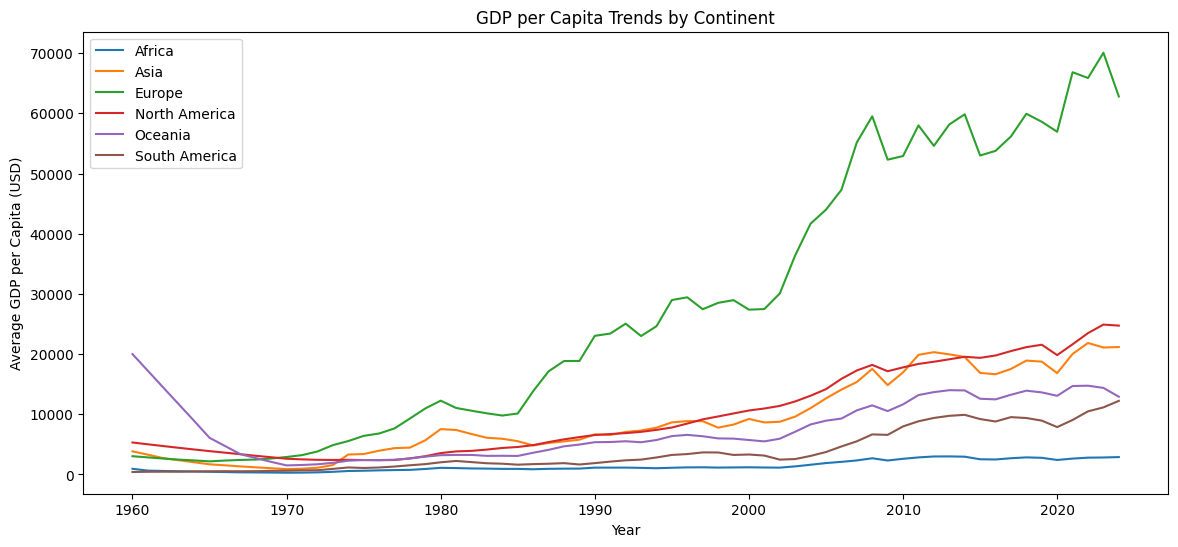

In [212]:
plt.figure(figsize=(14, 6))

for continent in continent_trends["Continent_Name"].unique():
    subset = continent_trends[continent_trends["Continent_Name"] == continent]
    plt.plot(subset["Year"], subset["GDP_per_capita"], label=continent)

plt.title("GDP per Capita Trends by Continent")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.legend()
plt.show()

- [X] Standardize GDP per capita (z-score) for a given year.
- [X] Identify outliers (countries >3 std deviations from mean).

In [213]:
# Standardize GDP per capita (z-score) for a given year.
year = np.random.randint(data_long["Year"].min(), data_long["Year"].max(), 1)[0]
random_year_data = data_long[data_long["Year"] == year].copy()
mean = random_year_data["GDP_per_capita"].mean()
std = random_year_data["GDP_per_capita"].std()
random_year_data["z_score"] = (random_year_data["GDP_per_capita"] - mean) / std
random_year_data

,Country,Continent_Name,Year,GDP_per_capita,z_score
55,Africa Eastern and Southern,NaN,2015,1479.615260,-0.596489
120,Africa Western and Central,NaN,2015,1860.727694,-0.581065
185,Andorra,Europe,2015,38654.934720,0.908040
250,Arab World,NaN,2015,6262.041685,-0.402939
315,United Arab Emirates,Asia,2015,43534.997269,1.105542
...,...,...,...,...,...
12795,World,NaN,2015,10175.409420,-0.244560
12860,Samoa,Oceania,2015,4084.360838,-0.491072
12925,South Africa,Africa,2015,6112.273825,-0.409000
12990,Zambia,Africa,2015,1295.877887,-0.603925


In [214]:
# Identify outliers (countries >3 std deviations from mean).
random_year_data[np.abs(random_year_data["z_score"]) > 3]

,Country,Continent_Name,Year,GDP_per_capita,z_score
1160,Bermuda,North America,2015,104855.366822,3.587250
6945,Liechtenstein,Europe,2015,167187.157310,6.109891
7335,Luxembourg,Europe,2015,105462.012584,3.611802
7465,Monaco,Europe,2015,170437.101188,6.241420


- [X] Line plot: GDP trends of top 5 largest economies (US, China, Japan, Germany, India).
- [X] Histogram: Distribution of GDP per capita for all countries in 2020.
- [X] Scatter plot: GDP per capita vs Year for China and India (compare growth paths).
- [X] Rolling mean (5-year window) for global GDP per capita trend (smooth line plot).

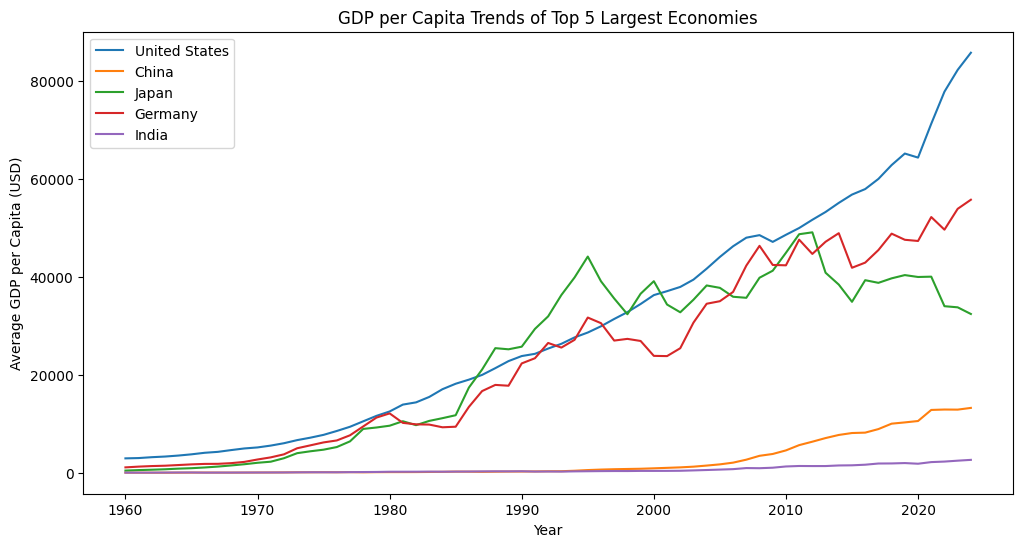

In [215]:
# GDP trends of top 5 largest economies (US, China, Japan, Germany, India).
countries = np.array(["United States", "China", "Japan", "Germany", "India"])

plt.figure(figsize=(12, 6))
largest_economies_data = data_long[data_long["Country"].isin(countries)]
for country in countries:
    subset = largest_economies_data[largest_economies_data["Country"] == country]
    plt.plot(subset["Year"], subset["GDP_per_capita"], label=country)

plt.title("GDP per Capita Trends of Top 5 Largest Economies")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.legend()
plt.show()


Text(0, 0.5, 'Count')

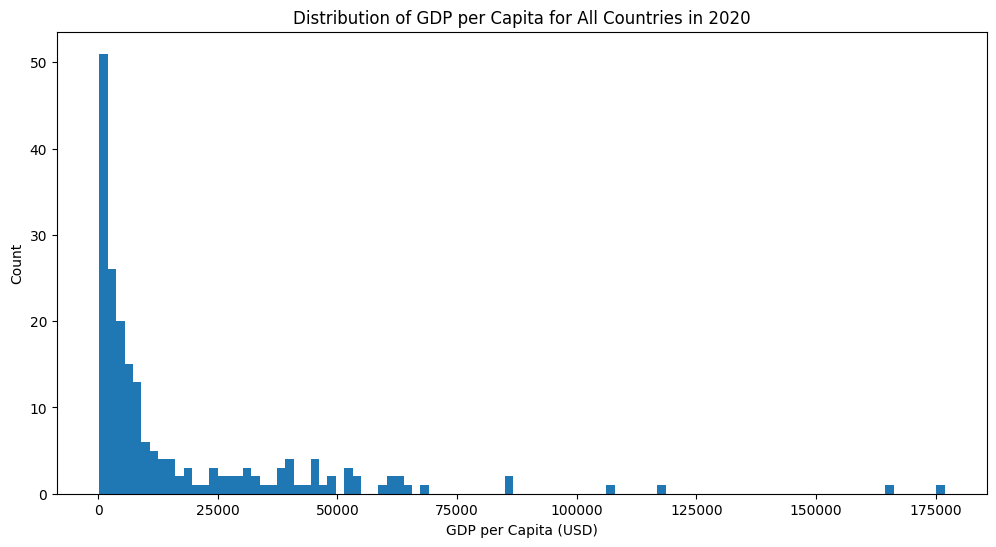

In [216]:
# Histogram: Distribution of GDP per capita for all countries in 2020.
certain_year_data = data_long[data_long["Year"] == 2020]

plt.figure(figsize=(12, 6))
plt.hist(certain_year_data["GDP_per_capita"], bins=100)
plt.title("Distribution of GDP per Capita for All Countries in 2020")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Count")

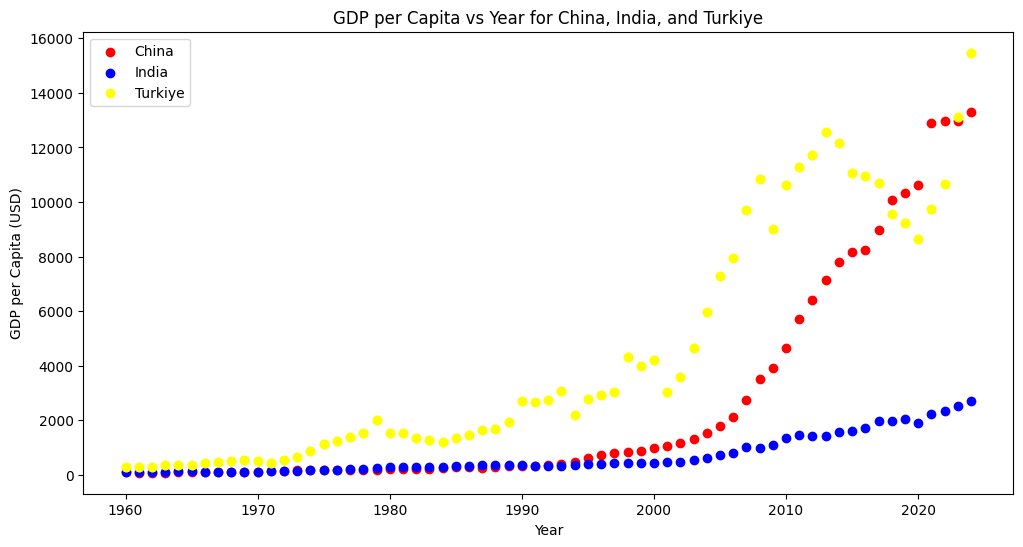

In [217]:
# Scatter plot: GDP per capita vs Year for China, India and, Turkiye (compare growth paths).
china_data = data_long[data_long["Country"] == "China"]
india_data = data_long[data_long["Country"] == "India"]
turkiye_data = data_long[data_long["Country"] == "Turkiye"]

plt.figure(figsize=(12, 6))
plt.scatter(china_data["Year"], china_data["GDP_per_capita"], label="China", color="red")
plt.scatter(india_data["Year"], india_data["GDP_per_capita"], label="India", color="blue")
plt.scatter(turkiye_data["Year"], turkiye_data["GDP_per_capita"], label="Turkiye", color="yellow")
plt.title("GDP per Capita vs Year for China, India, and Turkiye")
plt.xlabel("Year")
plt.ylabel("GDP per Capita (USD)")
plt.legend()
plt.show()

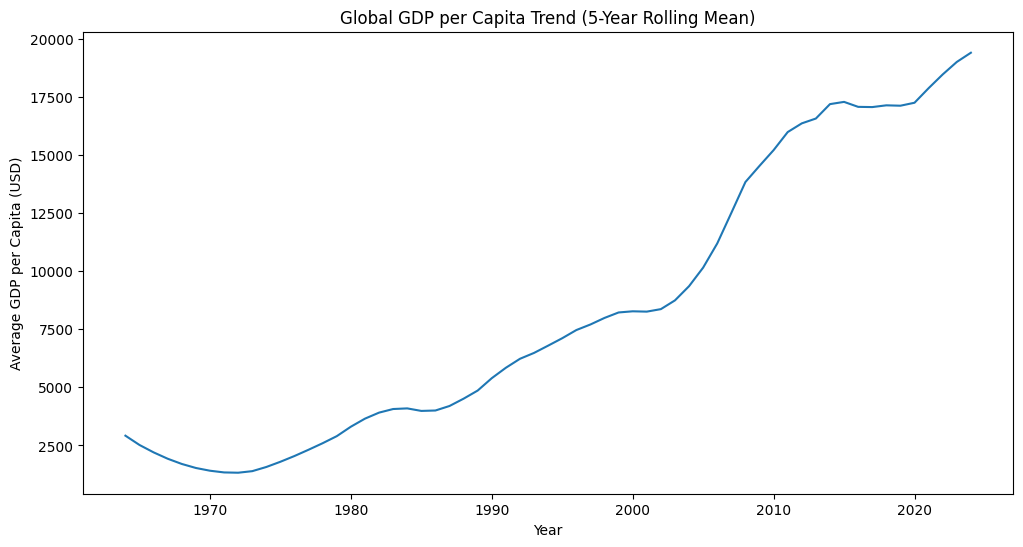

Year
1960     3821.655615
1961     3250.622696
1962     2856.368713
1963     2507.240473
1964     2168.600200
            ...     
2020    16846.293181
2021    19412.031519
2022    20049.416558
2023    20772.478072
2024    19864.352360
Name: GDP_per_capita, Length: 65, dtype: float64

In [218]:
# Rolling mean (5-year window) for global GDP per capita trend (smooth line plot).
global_gdp_per_year_smoothed = global_gdp_per_year.rolling(5).mean()
plt.figure(figsize=(12, 6))
plt.plot(global_gdp_per_year_smoothed)
plt.title("Global GDP per Capita Trend (5-Year Rolling Mean)")
plt.xlabel("Year")
plt.ylabel("Average GDP per Capita (USD)")
plt.show()
global_gdp_per_year